In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [2]:
TFtot = 2000
kon = 0.0016399 
koff_invert = 0.34393 / 4
koff_amp = 0.34393 * 2
kbasal_invert = 0.02612 
kbasal_amp = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p_amp =  kon, TFtot, koff_amp, kbasal_amp, kmax, n, Kd, kdegR, ktrans, kdegP
p_invert = kon, TFtot, koff_invert, kbasal_invert, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled_amp = kmax * kdegR / (kbasal_amp + kmax)
kbasal_scaled_amp = kbasal_amp * kdegR / (kbasal_amp + kmax)
k_alpha_amp = kon * 1000 / koff_amp
k_beta_amp = koff_amp 

p_scaled_amp = k_alpha_amp, k_beta_amp, kbasal_scaled_amp, kmax_scaled_amp, n, Kd_scaled, kdegR


Kd_scaled = Kd / TFtot
kmax_scaled_invert = kmax * kdegR / (kbasal_invert + kmax)
kbasal_scaled_invert = kbasal_invert * kdegR / (kbasal_invert + kmax)
k_alpha_invert = kon * 1000 / koff_invert
k_beta_invert = koff_invert

p_scaled_invert = k_alpha_invert, k_beta_invert, kbasal_scaled_invert, kmax_scaled_invert, n, Kd_scaled, kdegR


In [3]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step, p_scaled):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, p_scaled, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p, od_sp=None):

    # Parameters
    kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp = p

    # print(kdegR)

    x_guess = x
    global setpoint_amp, setpoint_invert
    # if setpoint is None:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    # else:
    #     out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    # mRNA_blind = 1
    

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

    dmRNA_invert_dt = (setpoint_invert[1] - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (setpoint_amp[1] - mRNA_amp) / tau_mRNA

    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
    ktrans_scaled_PDC_invert = ktrans  * ((mu_max_invert + kdegPPDC) / ktrans)
    
    dRepdt = ktrans_scaled_invert * mRNA_invert * S / (Ks + S) - (kdegP + mu_x_invert) * Rep
    dEnz_invert_dt = ktrans_scaled_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert
    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    # Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    ktrans_scaled_amp = ktrans  * ((mu_max_amp + kdegP) / ktrans)
    ktrans_scaled_PDC_amp = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
    
    dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp
    dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp
    # dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)
    # print('Amp decay: ' + str(kdegP + mu_x_amp))
    # print('Inv decay: ' + str(kdegP + mu_x_invert))
    # print('================================')

    S0 = 20
    if od_sp is None:
        d = 0
    else:
        d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
        if (X_invert + X_amp) < od_sp:
            d = 0
        elif (X_invert + X_amp) > od_sp:
            d = d #* (X_invert + X_amp)/od_sp
    
    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S)
    dX_invert_dt = mu_x_invert * X_invert - d * X_invert
    dX_amp_dt = mu_x_amp * X_amp - d * X_amp



    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [4]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.00
K_Rep = 0.01
K_Amp = 0.99

mu_max_invert = 0.0233 / 20
mu_max_amp = 0.014 / 20

# mu_max = mu_max_opto
Ks = 1
Y = 0.5

In [5]:
u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

In [6]:
from tqdm import tqdm

if True:

    u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

    # u_arr = np.flip(10 ** np.linspace(-1,0,100))
    Enz_arr = np.zeros(u_arr.size)
    mRNA_arr_amp = np.zeros(u_arr.size)
    mRNA_arr_invert = np.zeros(u_arr.size)

    setpoint_amp = None
    setpoint_invert = None

    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        # print(u)
        period = 100 / 60
        Imax = 1
        setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
        # print(setpoint)
        mRNAss = setpoint_amp[1]
        mRNA_arr_amp[i] = mRNAss

        setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

        mRNAss = setpoint_invert[1]
        mRNA_arr_invert[i] = mRNAss

        


100%|██████████| 101/101 [03:44<00:00,  2.23s/it]


[None, None, None, None]

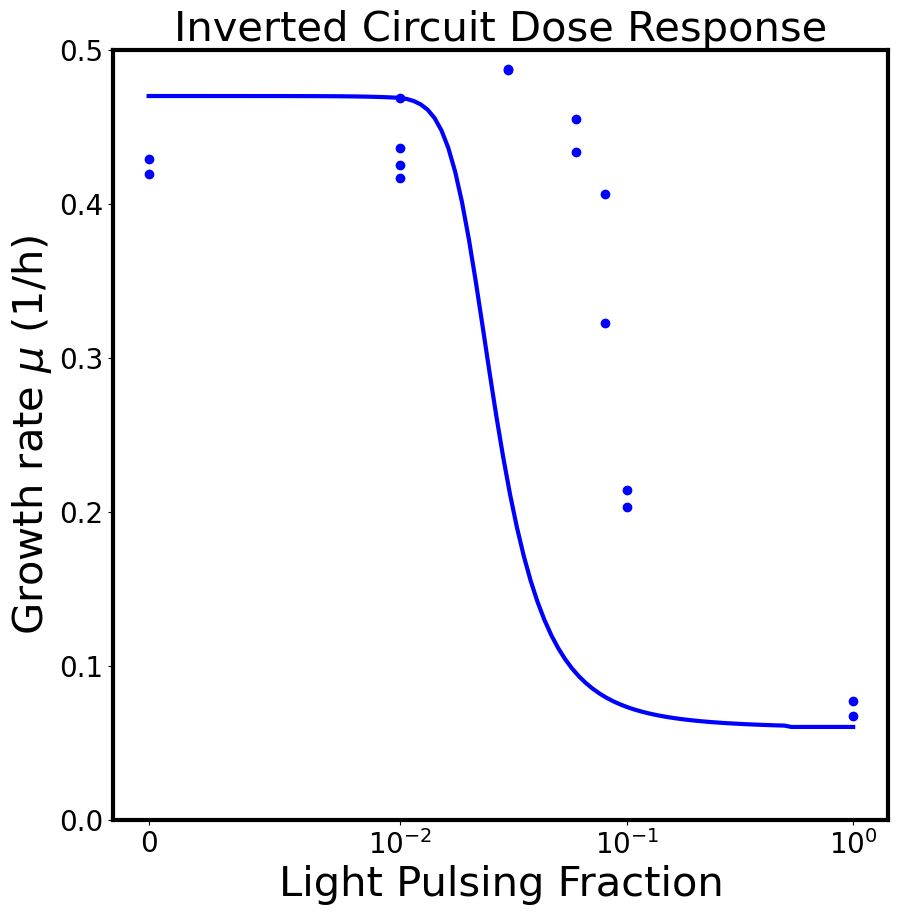

In [7]:
# Inverted Circuit
# 
# u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

kdegR = 0.042116
ktrans = 1.4514
kdegP = np.log(2) / (6 * 60)
kdegPPDC = np.log(2) / (12 * 60)
K_Rep = 0.3
n_Rep = 3
mu_max_invert = 0.47 / 60


import matplotlib.pyplot as plt

ktrans_scaled = ktrans  * ((mu_max_invert + kdegP) / ktrans)
ss_Rep = - (1 / (2 * mu_max_invert)) * (kdegP - np.sqrt(4 * mRNA_arr_invert * mu_max_invert * ktrans_scaled + kdegP ** 2))
ktrans_scaled_PDC = ktrans  * ((mu_max_invert + kdegPPDC) / ktrans)
# ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
# dEnz_invert_dt = ktrans_scaled_invert * (K_Rep / (K_Rep + Rep)) * S / (Ks + S) - (kdegP + mu_x_invert) * Enz_invert
ss_Enz = - (1 / (2 * mu_max_invert)) * (kdegPPDC - np.sqrt(4 * (K_Rep ** n_Rep / (K_Rep ** n_Rep + ss_Rep ** n_Rep)) * mu_max_invert * ktrans_scaled_PDC + kdegPPDC ** 2))

mu_arr_invert = ss_Enz * mu_max_invert * 60

# Real Data
mu_SGy104_1 = np.array([0.429016493, 0.419454997, 0.425278485, 0.468815929, 0.214066814, 0.202848859, 0.077447387, 0.067285511, 0.487083379, 0.487241995,
0.436233624, 0.416734105, 0.433773399, 0.4552301, 0.406627518, 0.322757789])
mu_SGy104_1_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(u_arr, mu_arr_invert, '-b', label='mu', linewidth=3)
ax.plot(mu_SGy104_1_lights, mu_SGy104_1, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Light Pulsing Fraction', fontsize=30)
ax.set_ylabel(r'Growth rate $\mu$ (1/h)', fontsize=30)
ax.set_title('Inverted Circuit Dose Response', fontsize=30)
ax.set_ylim([0, 0.5])
[i.set_linewidth(3) for i in ax.spines.values()]

# ax = fig.add_subplot(122)
# ax.plot(u_arr, ss_Rep, '-bx', label='mu')
# ax.set_xscale('symlog', linthresh=0.01)
# ax2 = ax.twinx()
# ax2.plot(u_arr, (K_Rep ** n_Rep / (K_Rep ** n_Rep + ss_Rep ** n_Rep)), '-rx', label='mu')
# ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


# print(max(mu_arr_invert))
# print(min(mu_arr_invert))
# print(- (1 / (2 * mu_max_invert)) * (kdegP - np.sqrt(4 * (K_Rep / (K_Rep + ss_Rep[0])) * mu_max_invert * ktrans_scaled + kdegP ** 2)))

# print(ss_Rep)
# print(u_arr)


0.4285845637355239
0.06652894732805273


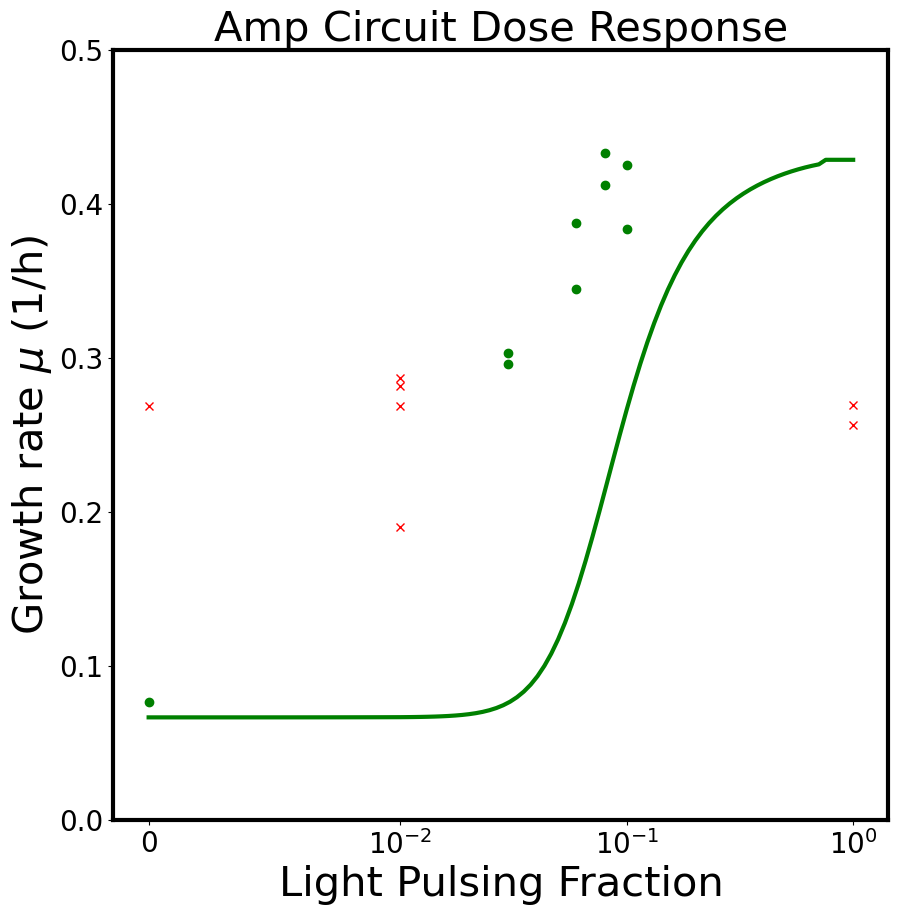

In [8]:
# Amp Circuit
K_Amp = 0.2
mu_max_amp = 0.47 / 60
n_Amp = 1.1

import matplotlib.pyplot as plt

# dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp
# dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

ktrans_scaled = ktrans  * ((mu_max_amp + kdegP) / ktrans)
ss_Amp = - (1 / (2 * mu_max_amp)) * (kdegP - np.sqrt(4 * mRNA_arr_amp * mu_max_amp * ktrans_scaled + kdegP ** 2))
ktrans_scaled_PDC = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
ss_Enz = - (1 / (2 * mu_max_amp)) * (kdegPPDC - np.sqrt(4 * (ss_Amp ** n_Amp / (K_Amp ** n_Amp + ss_Amp ** n_Amp)) * mu_max_amp * ktrans_scaled_PDC + kdegPPDC ** 2))

mu_arr_amp = ss_Enz * mu_max_amp * 60

# Real Data
mu_SGy128_4 = np.array([0.07654071, 0.26858448, 0.28688688, 0.19000113, 0.3834206 ,
       0.42503585, 0.25622547, 0.26932193, 0.30298274, 0.29615459,
       0.28158447, 0.26857221, 0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4_lags = np.array([ 0.        , 39.88279932, 19.98011315, 14.4137813 ,  0.        ,
        2.18260617,  0.        ,  1.21280087, 10.40812555,  7.77763666,
       21.22069601, 19.70771971,  1.68719277,  3.11811039,  2.52691981,
        2.30179095])
mu_SGy128_4_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])

mu_SGy128_4_rejects = np.array([0.26858448, 0.28688688, 0.19000113,  0.25622547, 0.26932193, 0.28158447, 0.26857221])
mu_SGy128_4_rejects_lights = np.array([0,  0.01, 0.01, 1, 1,  0.01, 0.01])

mu_SGy128_4_trues = np.array([0.07654071, 0.3834206 ,
       0.42503585, 0.30298274, 0.29615459,
       0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4__trues_lights = np.array([0, 0.1, 0.1, 0.03, 0.03, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(u_arr, mu_arr_amp, '-g', label='mu', linewidth=3)
ax.plot(mu_SGy128_4__trues_lights, mu_SGy128_4_trues, 'og', label='mu')
ax.plot(mu_SGy128_4_rejects_lights, mu_SGy128_4_rejects, 'xr', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Light Pulsing Fraction', fontsize=30)
ax.set_ylabel(r'Growth rate $\mu$ (1/h)', fontsize=30)
ax.set_title('Amp Circuit Dose Response', fontsize=30)
ax.set_ylim([0, 0.5])
[i.set_linewidth(3) for i in ax.spines.values()]

# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(121)
# ax.plot(u_arr, mu_arr_amp, '-x', label='mu')
# ax.plot(mu_SGy128_4_lights, mu_SGy128_4, 'ob', label='mu')
# ax.set_xscale('symlog', linthresh=0.01)

# ax = fig.add_subplot(122)
# ax.plot(u_arr, ss_Amp, '-x', label='mu')
# ax.set_xscale('symlog', linthresh=0.01)
# ax2 = ax.twinx()
# ax2.plot(u_arr, (ss_Amp / (K_Amp + ss_Amp)), '-rx', label='mu')
# ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


print(max(mu_arr_amp))
print(min(mu_arr_amp))

[None, None, None, None]

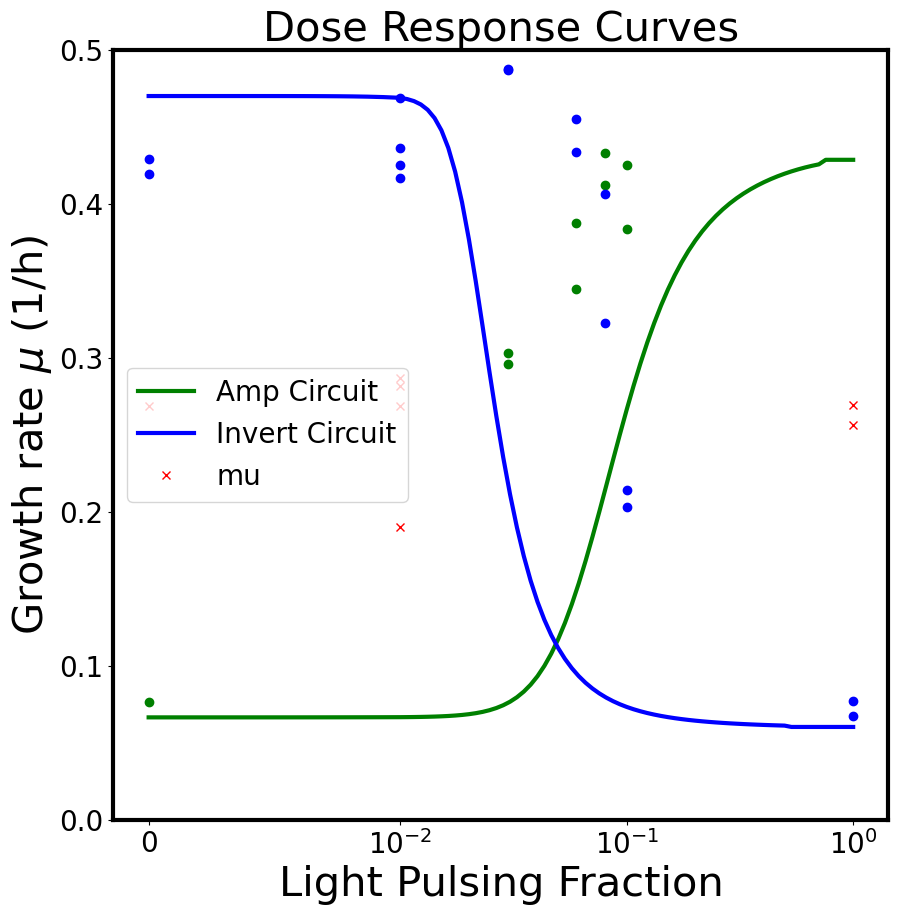

In [9]:
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(121)
# ax.plot(u_arr, mu_arr_amp, '-x', label='mu_amp')
# ax.plot(u_arr, mu_arr_invert, '-x', label='mu_invert')
# ax.set_xscale('symlog', linthresh=0.01)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(u_arr, mu_arr_amp, '-g', label='Amp Circuit', linewidth=3)
ax.plot(mu_SGy128_4__trues_lights, mu_SGy128_4_trues, 'og')
ax.plot(u_arr, mu_arr_invert, '-b', label='Invert Circuit', linewidth=3)
ax.plot(mu_SGy104_1_lights, mu_SGy104_1, 'ob')
ax.plot(mu_SGy128_4_rejects_lights, mu_SGy128_4_rejects, 'xr', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Light Pulsing Fraction', fontsize=30)
ax.set_ylabel(r'Growth rate $\mu$ (1/h)', fontsize=30)
ax.set_title('Dose Response Curves', fontsize=30)
plt.legend(fontsize=20)
ax.set_ylim([0, 0.5])
[i.set_linewidth(3) for i in ax.spines.values()]

0
The solver successfully reached the end of the integration interval.
True


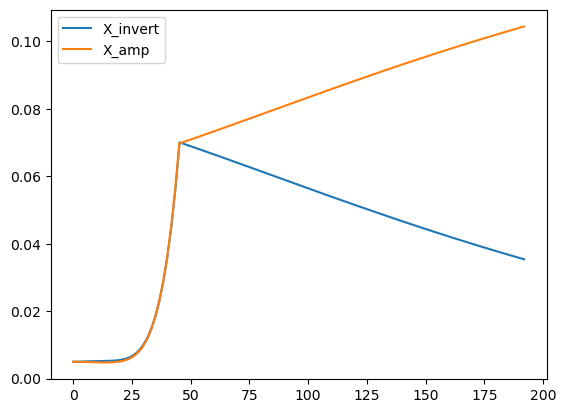

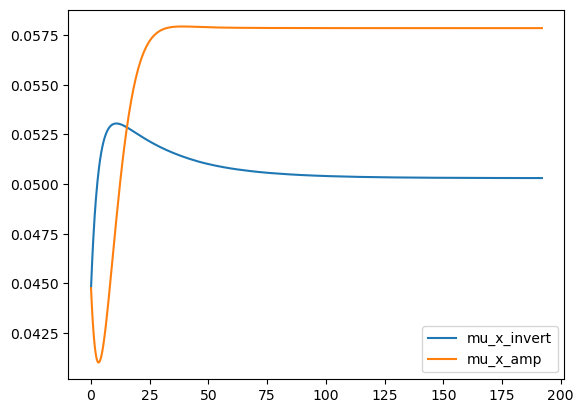

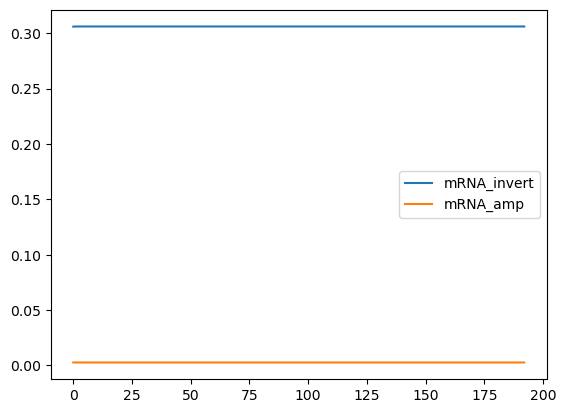

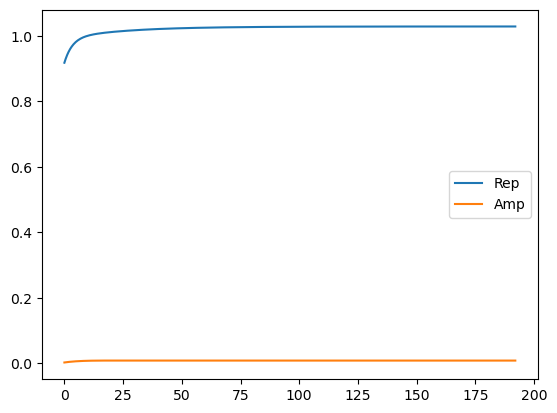

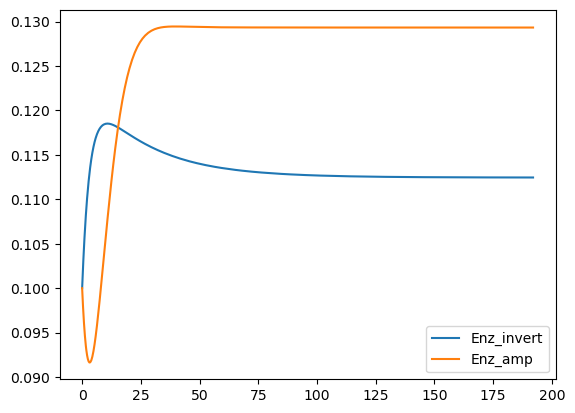

In [10]:
from scipy.interpolate import interp1d


t_final = 192

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp



tspan = [0, t_final*60]
u = 0.034
od_sp = 0.01

mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)
mRNA_funs = [mRNA_invert_fun, mRNA_amp_fun]

def u_fun(t):
    return u

x_init = [u, u, u, u, 1-u, u, 20, 0.01, 0.01]

x_init = np.array([mRNA_invert_fun(u), mRNA_amp_fun(u), mRNA_invert_fun(u)*3, mRNA_amp_fun(u), 0.1, 0.1, 20, 0.005, 0.005])

period = 100 / 60
Imax = 1

setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y



mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
X_invert = X_invert_x
X_amp = X_amp_x
t_arr = sol.t

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()

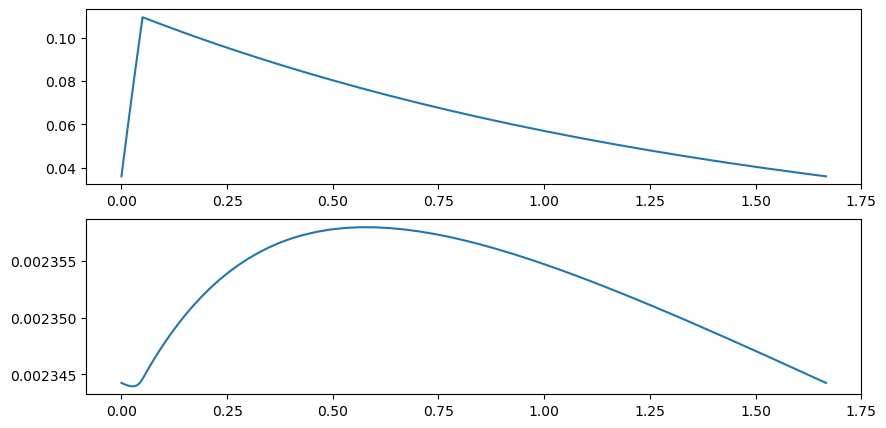

In [11]:
period = 100 / 60
Imax = 1
u = 0.03
x_guess = None
p_scaled = p_scaled_amp

I = lambda t: I_fun_base(t, u, period, Imax)

if x_guess is None:
    x_guess = [u,u]

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

# try:
#     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
# except:
#     print('first one failed')
#     x_guess = [u,u]
#     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
# steady = sol


sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)
if not sol.success:
    x_guess = [u,u]
    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)

steady = np.maximum(sol.x,[0,0])
tspan = [0,period]
sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                    rtol=1e-9, atol=1e-12, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    max_step=max_step,
                    )


fig = plt.figure(facecolor='white', figsize=(10,5))
ax = fig.add_subplot(211)
ax.plot(sol.t, sol.y[0], label='TF')

ax = fig.add_subplot(212)
ax.plot(sol.t, sol.y[1], label='mRNA')


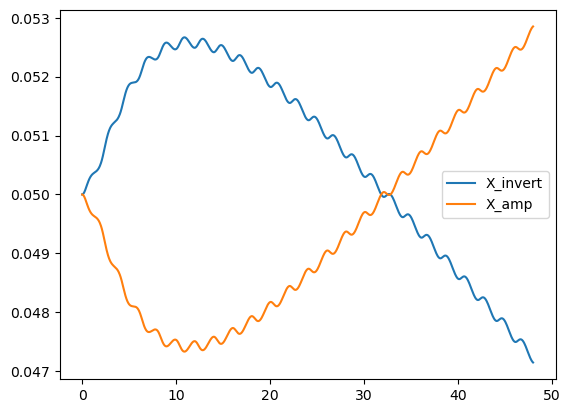

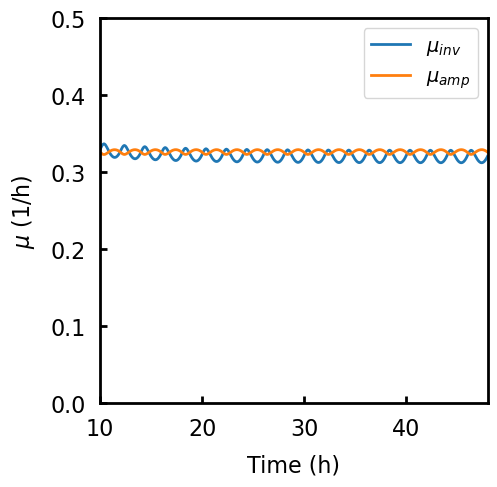

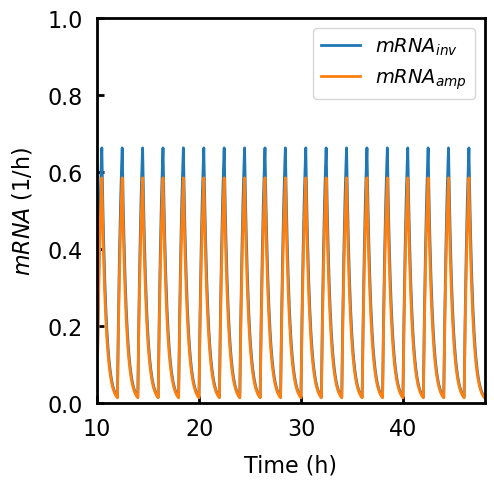

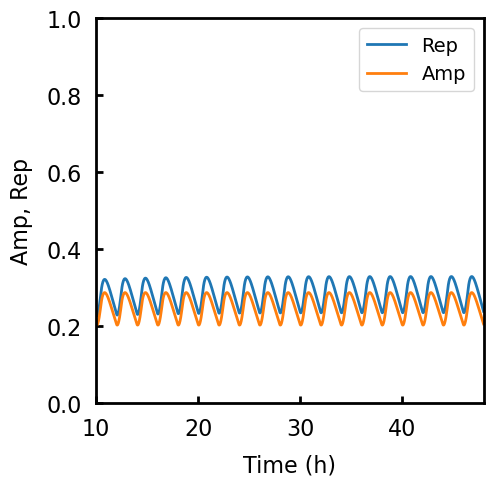

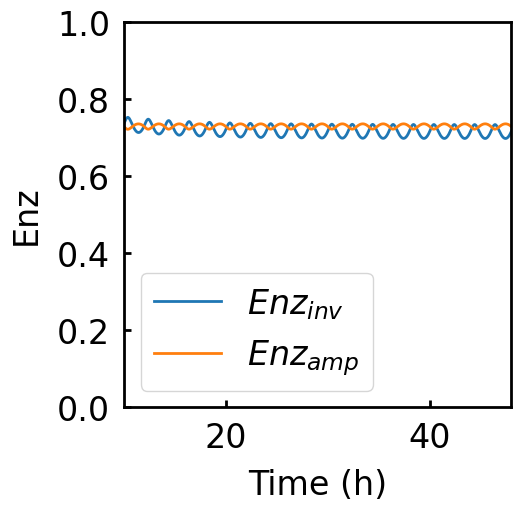

In [18]:
mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)


macro_period = 2
macro_pulse = 0.235
t_final = 48

od_sp = 0.01

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 0, 0.2, 0.2, 0.8, 0.8, 20, 0.05, 0.05]

t_span_arr = [0]
while t_span_arr[-1] < t_final * 60:
    last_t = t_span_arr[-1]
    t_span_arr.append(last_t + macro_pulse * macro_period * 60)
    t_span_arr.append(last_t + macro_period * 60)
tspan_arr = np.array(t_span_arr)
# tspan_arr = np.linspace(0, 24, 25) * 60
u_arr_macro = [1, 0] * int((tspan_arr.size-1)/2)

def u_fun(t):
    if t/60 % macro_period < macro_pulse:
        return 1
    else:
        return 0

mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = [], [], [], [], [], [], [], [], []
t_arr = []

for i in range(len(u_arr_macro)):
    tspan = [tspan_arr[i], tspan_arr[i+1]]
    u = u_arr_macro[i]

    period = 100 / 60
    Imax = 1

    setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
    setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y
    
    mRNA_invert.append(mRNA_invert_x)
    mRNA_amp.append(mRNA_amp_x)
    Rep.append(Rep_x)
    Amp.append(Amp_x)
    Enz_invert.append(Enz_invert_x)
    Enz_amp.append(Enz_amp_x)
    S.append(S_x)
    X_invert.append(X_invert_x)
    X_amp.append(X_amp_x)
    t_arr.append(sol.t)


mRNA_invert = np.hstack(mRNA_invert)
mRNA_amp = np.hstack(mRNA_amp)
Rep = np.hstack(Rep)
Amp = np.hstack(Amp)
Enz_invert = np.hstack(Enz_invert)
Enz_amp = np.hstack(Enz_amp)
S = np.hstack(S)
X_invert = np.hstack(X_invert)
X_amp = np.hstack(X_amp)
t_arr = np.hstack(t_arr)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, mu_x_invert, label=r'$\mu_{inv}$', linewidth=2)
ax.plot(t_arr/60, mu_x_amp, label=r'$\mu_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$\mu$ (1/h)', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 0.5])
plt.legend(fontsize=14)


plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, mRNA_invert, label=r'$mRNA_{inv}$', linewidth=2)
ax.plot(t_arr/60, mRNA_amp, label=r'$mRNA_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$mRNA$ (1/h)', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=14)

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, Rep, label=r'Rep', linewidth=2)
ax.plot(t_arr/60, Amp, label=r'Amp', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'Amp, Rep', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=14)

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, Enz_invert, label=r'$Enz_{inv}$', linewidth=2)
ax.plot(t_arr/60, Enz_amp, label=r'$Enz_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=24, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=24, labelpad=10)
ax.set_ylabel(r'Enz', fontsize=24, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=24)

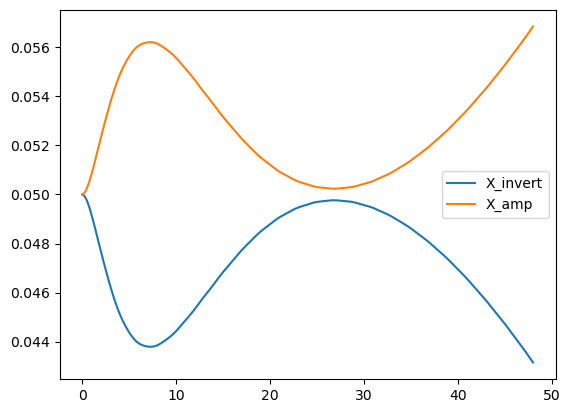

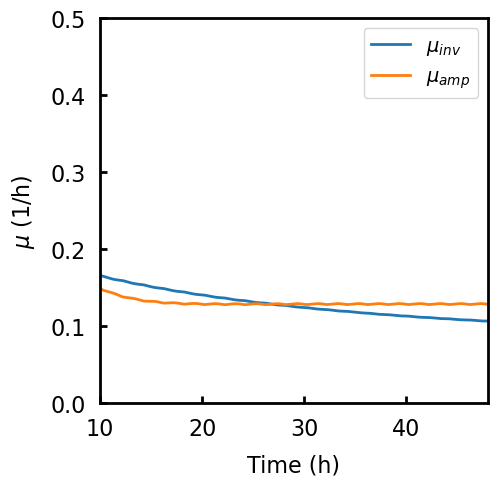

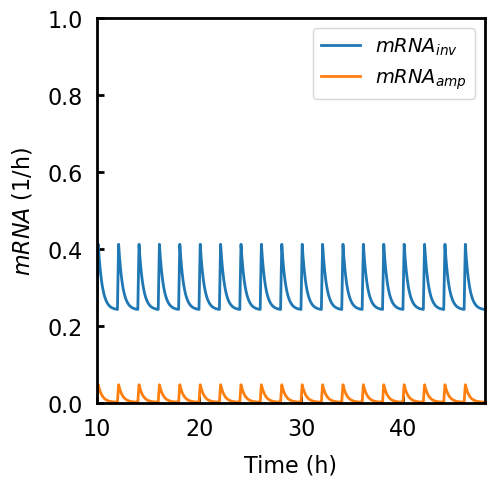

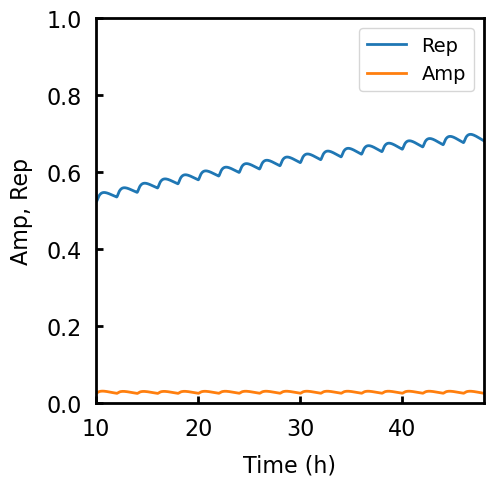

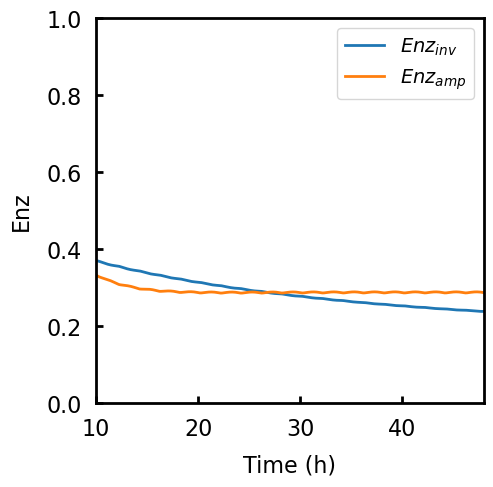

In [13]:
mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)


macro_period = 2
macro_pulse = 0.06
t_final = 48

od_sp = 0.01

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 0, 0.7, 0.2, 0.8, 0.8, 20, 0.05, 0.05]

t_span_arr = [0]
while t_span_arr[-1] < t_final * 60:
    last_t = t_span_arr[-1]
    t_span_arr.append(last_t + macro_pulse * macro_period * 60)
    t_span_arr.append(last_t + macro_period * 60)
tspan_arr = np.array(t_span_arr)
# tspan_arr = np.linspace(0, 24, 25) * 60
u_arr_macro = [0.2, 0.03] * int((tspan_arr.size-1)/2)
setpoint_amp_arr = [steady_mRNA_solve(u_arr_macro[0], period, Imax, p_scaled_amp, x_guess=setpoint_amp), steady_mRNA_solve(u_arr_macro[1], period, Imax, p_scaled_amp, x_guess=setpoint_amp),] * (tspan_arr.size-1)
setpoint_invert_arr = [steady_mRNA_solve(u_arr_macro[0], period, Imax, p_scaled_invert, x_guess=setpoint_invert), steady_mRNA_solve(u_arr_macro[1], period, Imax, p_scaled_invert, x_guess=setpoint_invert),] * (tspan_arr.size-1)

mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = [], [], [], [], [], [], [], [], []
t_arr = []

for i in range(len(u_arr_macro)):
    # print(i, tspan_arr[i+1]/60)
    tspan = [tspan_arr[i], tspan_arr[i+1]]
    u = u_arr_macro[i]
    setpoint_amp = setpoint_amp_arr[i]
    setpoint_invert = setpoint_invert_arr[i]

    period = 100 / 60
    Imax = 1

    # setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
    # setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)


    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y
    
    mRNA_invert.append(mRNA_invert_x)
    mRNA_amp.append(mRNA_amp_x)
    Rep.append(Rep_x)
    Amp.append(Amp_x)
    Enz_invert.append(Enz_invert_x)
    Enz_amp.append(Enz_amp_x)
    S.append(S_x)
    X_invert.append(X_invert_x)
    X_amp.append(X_amp_x)
    t_arr.append(sol.t)


mRNA_invert = np.hstack(mRNA_invert)
mRNA_amp = np.hstack(mRNA_amp)
Rep = np.hstack(Rep)
Amp = np.hstack(Amp)
Enz_invert = np.hstack(Enz_invert)
Enz_amp = np.hstack(Enz_amp)
S = np.hstack(S)
X_invert = np.hstack(X_invert)
X_amp = np.hstack(X_amp)
t_arr = np.hstack(t_arr)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, mu_x_invert, label=r'$\mu_{inv}$', linewidth=2)
ax.plot(t_arr/60, mu_x_amp, label=r'$\mu_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$\mu$ (1/h)', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 0.5])
plt.legend(fontsize=14)


plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, mRNA_invert, label=r'$mRNA_{inv}$', linewidth=2)
ax.plot(t_arr/60, mRNA_amp, label=r'$mRNA_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$mRNA$ (1/h)', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=14)

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, Rep, label=r'Rep', linewidth=2)
ax.plot(t_arr/60, Amp, label=r'Amp', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'Amp, Rep', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=14)

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, Enz_invert, label=r'$Enz_{inv}$', linewidth=2)
ax.plot(t_arr/60, Enz_amp, label=r'$Enz_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'Enz', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=14)

In [14]:
print(kdegP)
print(kdegPPDC)

0.001925408834888737
0.0009627044174443685


0
The solver successfully reached the end of the integration interval.
True


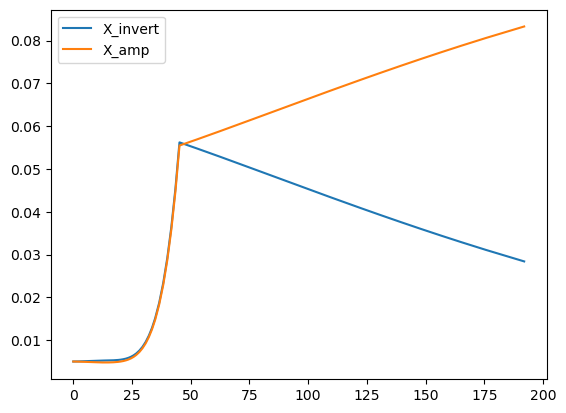

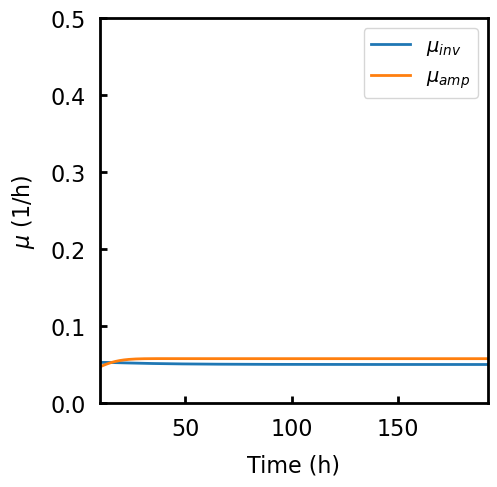

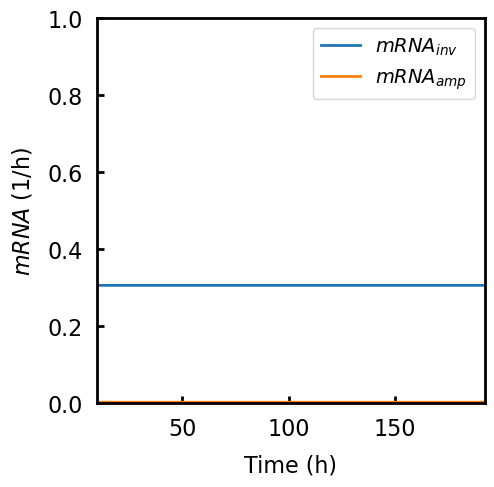

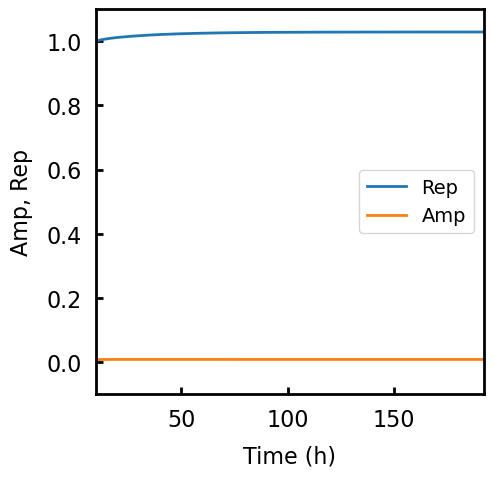

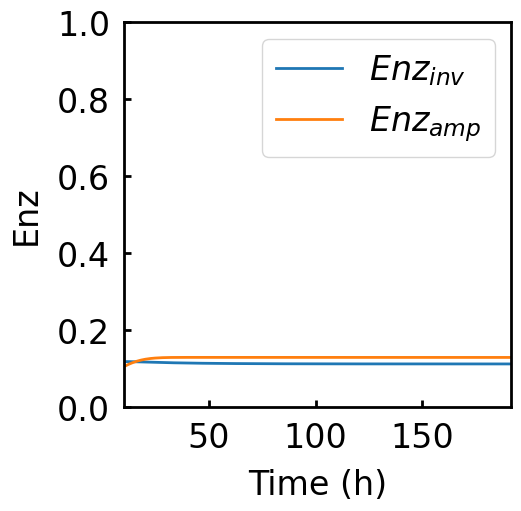

In [19]:
from scipy.interpolate import interp1d


t_final = 192

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp



tspan = [0, t_final*60]
u = 0.034
od_sp = 0.01

mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)
mRNA_funs = [mRNA_invert_fun, mRNA_amp_fun]

def u_fun(t):
    return u

x_init = [u, u, u, u, 1-u, u, 20, 0.01, 0.01]

x_init = np.array([mRNA_invert_fun(u), mRNA_amp_fun(u), mRNA_invert_fun(u)*3, mRNA_amp_fun(u), 0.1, 0.1, 20, 0.005, 0.005])

period = 100 / 60
Imax = 1

setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y



mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
X_invert = X_invert_x
X_amp = X_amp_x
t_arr = sol.t

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, mu_x_invert, label=r'$\mu_{inv}$', linewidth=2)
ax.plot(t_arr/60, mu_x_amp, label=r'$\mu_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$\mu$ (1/h)', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 0.5])
plt.legend(fontsize=14)


plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, mRNA_invert, label=r'$mRNA_{inv}$', linewidth=2)
ax.plot(t_arr/60, mRNA_amp, label=r'$mRNA_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$mRNA$ (1/h)', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=14)

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, Rep, label=r'Rep', linewidth=2)
ax.plot(t_arr/60, Amp, label=r'Amp', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=16, labelpad=10)
ax.set_ylabel(r'Amp, Rep', fontsize=16, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([-0.1, 1.1])
plt.legend(fontsize=14)

plt.figure(facecolor='white', figsize=(5,5))
ax = plt.subplot(111)
ax.plot(t_arr/60, Enz_invert, label=r'$Enz_{inv}$', linewidth=2)
ax.plot(t_arr/60, Enz_amp, label=r'$Enz_{amp}$', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=24, pad=10, length=5, width=2, direction='in')
ax.set_xlabel('Time (h)', fontsize=24, labelpad=10)
ax.set_ylabel(r'Enz', fontsize=24, labelpad=10)
[i.set_linewidth(2) for i in ax.spines.values()]
ax.set_xlim([10, t_final])
ax.set_ylim([0, 1])
plt.legend(fontsize=24)

/tmp/ipykernel_3598440/3988954247.py:165: RuntimeWarning: invalid value encountered in double_scalars
  d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)


[7.91513839e-03 7.21031044e-03 1.94525336e+00 3.69936432e-01
 2.16214281e-02 6.48638736e-01 1.99800000e+01 1.00000000e-02
 0.00000000e+00] The solution converged.
[2.45203544e-01 3.17584888e-03 1.34526790e+00 2.85512917e-02
 6.02812858e-02 1.06629180e-01 1.99800000e+01 1.00000000e-02
 0.00000000e+00] The solution converged.


array([ 0.00420836,  0.00112474,  0.0459235 ,  0.00250668, -0.00107467,
        0.00118488,  0.        ,  0.        ,  0.        ])

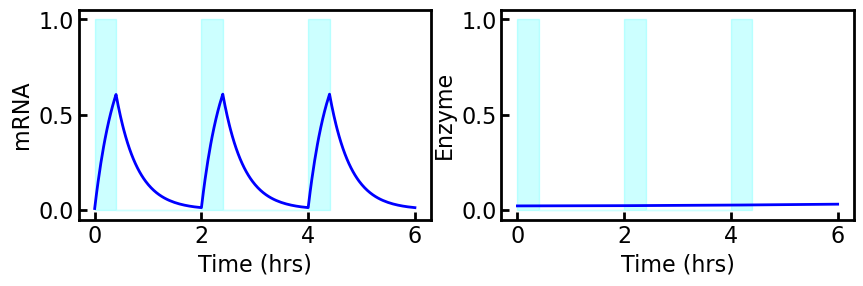

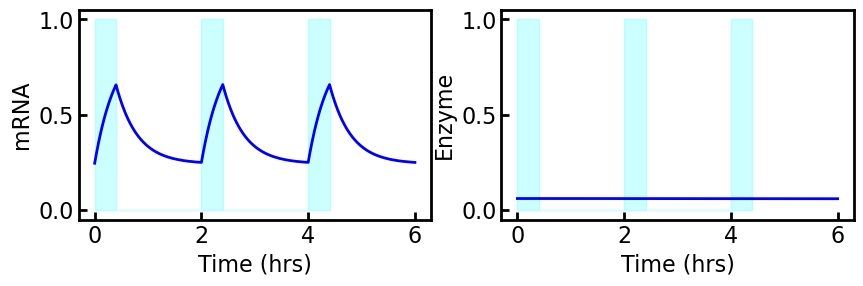

In [20]:
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

macro_period = 2
macro_pulse = 0.2
t_final = 48

od_sp = 0.01

S0 = 20

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)

def macropulse_fsolvefun(x, optogrowth_p, high=1, low=0, plot=False):

    global setpoint_invert, setpoint_amp

    x_orig = x.copy()

    setpoint_invert = np.array([0, mRNA_invert_fun(high)])
    setpoint_amp = np.array([0, mRNA_amp_fun(high)])

    # print(setpoint_invert)
    # print(setpoint_amp)
    # print('--------------------')

    x[-3] = S0 - od_sp / Y
    x[-2] = od_sp
    x[-1] = 0

    sol = solve_ivp(opto_growth, t_span=np.array([0, high*macro_period*60]), y0=x, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
#     print('solveIvp', sol.message)
    x_init_inv = sol.y[:,-1]

    setpoint_invert = np.array([0, mRNA_invert_fun(low)])
    setpoint_amp = np.array([0, mRNA_amp_fun(low)])
    # print(setpoint_invert)
    # print(setpoint_amp)
    # print('===============================')

    sol2 = solve_ivp(opto_growth, t_span=np.array([low*macro_period*60, macro_period*60]), y0=x_init_inv, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
#     print('solveIvp', sol.message)
    x_init_inv = sol2.y[:,-1]

    if plot:
        # fig = plt.figure(figsize=(10,5))
        # ax = fig.add_subplot(111)
        # ax.plot(sol.t/60, sol.y[4], '-b', label='OD')
        # ax.plot(sol2.t/60, sol2.y[4], '-r', label='OD2')

        t_plot = []
        sol_plot = []
        u_plot = []
        t_u_plot = []

        t_start = 0
        t_final = t_start + macro_period*60*macro_pulse
        x_init_inv = x
        for i in range(3):

            # print(np.array([t_start, t_final]))
            setpoint_invert = np.array([0, mRNA_invert_fun(high)])
            setpoint_amp = np.array([0, mRNA_amp_fun(high)])

            t_u_plot.append(t_start)
            t_u_plot.append(t_start)
            u_plot.append(0)
            u_plot.append(1)

            sol = solve_ivp(opto_growth, t_span=np.array([t_start, t_final]), y0=x_init_inv, args=(optogrowth_p,od_sp),
                                rtol=1e-6, atol=1e-9, 
                                method='BDF',
                                first_step = 0.0001,
                                )
        #     print('solveIvp', sol.message)
            x_init_inv = sol.y[:,-1]

            setpoint_invert = np.array([0, mRNA_invert_fun(low)])
            setpoint_amp = np.array([0, mRNA_amp_fun(low)])

            t_plot.append(sol.t)
            sol_plot.append(sol.y)

            t_u_plot.append(t_final)
            t_u_plot.append(t_final)
            u_plot.append(1)
            u_plot.append(0)

            # print(np.array([t_final, t_start+macro_period*60]))
            sol2 = solve_ivp(opto_growth, t_span=np.array([t_final, t_start+macro_period*60]), y0=x_init_inv, args=(optogrowth_p,od_sp),
                                rtol=1e-6, atol=1e-9, 
                                method='BDF',
                                first_step = 0.0001,
                                )
        #     print('solveIvp', sol.message)
            x_init_inv = sol2.y[:,-1]
            t_plot.append(sol2.t)
            sol_plot.append(sol2.y)

            t_start = t_start + macro_period*60
            t_final = t_final + macro_period*60

        t_plot = np.concatenate(t_plot)
        sol_plot = np.concatenate(sol_plot, axis=1)
        t_u_plot = np.array(t_u_plot)
        u_plot = np.array(u_plot)

        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(221)
        ax.plot(t_plot/60, sol_plot[0], '-b', label='OD2', linewidth=2)
        ax.fill_between(t_u_plot/60, u_plot, 0, color='cyan', alpha=0.2)
        ax.set_xlabel('Time (hrs)', fontsize=16)
        ax.set_ylabel('mRNA', fontsize=16)
        ax.set_ylim([-0.05,1.05])
        ax.tick_params(labelsize=16, axis='both', direction='in', length=6, width=2)
        [i.set_linewidth(2) for i in ax.spines.values()]
        

        ax = fig.add_subplot(222)
        ax.plot(t_plot/60, sol_plot[4], '-b', label='OD2', linewidth=2)
        ax.fill_between(t_u_plot/60, u_plot, 0, color='cyan', alpha=0.2)
        ax.tick_params(labelsize=16, axis='both', direction='in', length=6, width=2)
        ax.set_xlabel('Time (hrs)', fontsize=16)
        ax.set_ylabel('Enzyme', fontsize=16)
        # ax.set_ylim([-0.05,1.05])
        [i.set_linewidth(2) for i in ax.spines.values()]

    return (x_init_inv - x)

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, 0, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp
x_guess = [10, 10, 10, 10, 10, 10, 20, 10, 10]
x_init_invert, infodict, ier, mesg = fsolve(macropulse_fsolvefun, x_guess, args=(optogrowth_p,1,0), xtol=1e-9, maxfev=10000, full_output=True, factor=0.01)
x_init_invert2, infodict, ier, mesg = fsolve(macropulse_fsolvefun, x_guess, args=(optogrowth_p,0.2,0.03), xtol=1e-9, maxfev=10000, full_output=True, factor=0.01)
# print('invert', ier, mesg)
print(x_init_invert, mesg)
print(x_init_invert2, mesg)

macropulse_fsolvefun(x_init_invert, optogrowth_p, 1,0, plot=True)
macropulse_fsolvefun(x_init_invert2, optogrowth_p,0.2,0.03, plot=True)

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x